In [68]:
from pickle import TRUE
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from datetime import timedelta
import email.utils as eutils
import time
import math
# import streamlit as st
import eppy as eppy
from eppy import modeleditor
from eppy.modeleditor import IDF
from eppy.runner.run_functions import runIDFs
import PySimpleGUI as sg
# from PIL import Image, ImageTk
import os
from eppy.results import readhtml # the eppy module with functions to read the html
from eppy.results import fasthtml
import subprocess
import os
from os import system
import pylatex

from pylatex import Document, PageStyle, Head, MiniPage, Foot, LargeText, \
    MediumText, LineBreak, simple_page_number
from pylatex.utils import bold
from pylatex import Section, Subsection, Tabular, Math, TikZ, Axis, \
    Plot, Figure, Matrix, Alignat
from pylatex.utils import italic

In [69]:
def adorb(BaseFileName, studyFolder, databases, analysisPeriod, annualElec, annualGas, annualCO2, dirMR, emCO2, eTrans):
    results = pd.DataFrame(columns=['pv_dirEn', 'pv_opCO2', 'pv_dirMR', 'pv_emCO2', 'pv_eTrans'])
    years = range(analysisPeriod)
    pv = []
    r2 = []
    pc= 0.25
    # Dependencies and databasing
    # NatEmiss = pd.read_csv('NatlEmission.csv')

    k_dirEn = 0.02
    k_opCarb = 0.075
    k_dirMR = 0.02
    k_emCarb = 0
    k_sysTran = 0.02

    # annual sum of all high level sub routines, run those first then run 
    for i in years:
        c_dirMR = []
        year = i+1
        
        # Direct energy costs
        pv_dirEn = (annualElec+ annualGas)/((1+k_dirEn)**year)

        # Cost of operational carbon
        c_opCarb = annualCO2 * pc
        pv_opCO2 = c_opCarb/((1+k_opCarb)**year)

        # Cost of embodied carbon

        # For Level 1 embodied carbon calc (national emissions intensity based):

        # Right now there is no decarbonization glide path applied to embodied emissions (i.e. of recurring equipment replacements).

        # C_emCarb_y = (emMat_y + emLbr_y)*Pc
        # emMat_y is the embodied emissions due of the material items in year y [kg]
        # emLbr_y is the embodied emissions due to domestic / installation labor of the items in year y [kg]

        # emMat_y = sum, over the project retrofit and maintenance items, of emMat_item_y
        # emMat_item_y is the embodied emissions of the material item [kg].

        # emMat_item_y = C_dirMR_item_y * (1-LF_item_y) * EF(CoO_item_y)
        # LF_item_y is the fraction of install labor in C_dirMR_item_y [fraction 0 to 1].
        # EF(country) is the national emission factor of a country [kg/$].
        # CoO_item_y is the country of origin for the item occurring in year y.

        # EF(country) = CO2_country / GDP_country * 1000
        # CO2_country is the annual CO2e emissions from the country [Megatons].
        # GDP_country is the annual gross domestic product of the country [USD millions].

        # EF, CO2 and GDP data for the top 15 US trading partners is shown in Table 1.

        # emLbr_y = sum, over the project retrofit and maintenance items, of emLbr_item_y
        # emLbr_item_y is the embodied emissions due to labor, of the item occurring in year y.

        # emLbr_item_y = C_dirMR_item_y * LF_item_y * EF(COPL)
        # COPL is the country of the project location / building site.


        c_emCO2 = []
        for row in emCO2:
            if row[1] == i:
                c_emCO2.append(0.75*(row[0]/((1+k_emCarb)**year)))
            else:
                c_emCO2.append(0)
        pv_emCO2 = sum(c_emCO2)

        # Cost of direct maint / retrofit
        for row in dirMR:
            # c_dirMR = []
            if row[1] == i:
                c_dirMR.append(row[0]/((1+k_dirMR)**year))
            else:
                c_dirMR.append(0)
        pv_dirMR = sum(c_dirMR)

        # Cost of energy transition
        
        # TCF_y is the transition cost factor for year y. [$/Watt.yr]
        ytt = 30
        NTC = 4.5e12 # for US
        NNCI = 1600 # for US
        NTCF = NTC / (NNCI * 1e9)

        if year > ytt:
            TCF_y = 0 
        else:
            TCF_y = NTCF / ytt 	#linear transition

        C_eTran_y = TCF_y * eTrans

        pv_eTrans = (C_eTran_y)/((1+k_sysTran)**year)

        pv.append((pv_dirEn + pv_opCO2 + pv_dirMR + pv_emCO2 + pv_eTrans))
        newRow = pd.Series({'pv_dirEn':pv_dirEn, 'pv_opCO2':pv_opCO2, 'pv_dirMR':pv_dirMR, 'pv_emCO2':pv_emCO2, 'pv_eTrans':pv_eTrans})
        results = pd.concat([results, newRow.to_frame().T], ignore_index=True)
    results.to_csv(str(BaseFileName) + '_ADORBresults.csv')

    df = results

    df2 = pd.DataFrame()
    df2['pv_dirEn'] = df['pv_dirEn'].cumsum()
    df2['pv_dirMR'] = df['pv_dirMR'].cumsum()
    df2['pv_opCO2'] = df['pv_opCO2'].cumsum()
    df2['pv_emCO2'] = df['pv_emCO2'].cumsum()
    df2['pv_eTrans'] = df['pv_eTrans'].cumsum()

    # df2.plot(kind='area', xlabel='Years', ylabel='Cummulative Present Value [$]', title='ADORB COST', figsize=(6.5,8.5))
    fig = df2.plot(kind='area', xlabel='Years', ylabel='Cummulative Present Value [$]', title=(str(BaseFileName) + '_ADORB COST'), figsize=(10,6)).get_figure()
    
    adorb.adorbWedgeGraph = (str(studyFolder) + "/" + str(BaseFileName) + '_ADORB_Wedge.png')
    adorb.adorbBarGraph = (str(studyFolder) + "/" + str(BaseFileName) + '_ADORB_Bar.png')
    fig.savefig(str(adorb.adorbWedgeGraph))


    pv_dirEn_tot = df['pv_dirEn'].sum()
    pv_dirMR_tot = df['pv_dirMR'].sum()
    pv_opCO2_tot = df['pv_opCO2'].sum()
    pv_emCO2_tot = df['pv_emCO2'].sum()
    pv_eTrans_tot = df['pv_eTrans'].sum()

    if 'BASE' not in BaseFileName:
        for filename in os.listdir(studyFolder):
            if filename.endswith('.csv'):
                if 'BASE' in str(filename):
                    if 'ADORB' in str(filename):
                        basedf = pd.read_csv(filename)

                        pv_dirEn_tot_base = basedf['pv_dirEn'].sum()
                        pv_dirMR_tot_base = basedf['pv_dirMR'].sum()
                        pv_opCO2_tot_base = basedf['pv_opCO2'].sum()
                        pv_emCO2_tot_base = basedf['pv_emCO2'].sum()
                        pv_eTrans_tot_base = basedf['pv_eTrans'].sum()

                        case = ('Base Case','Proposed')
                        case_data = {
                            "Direct Energy": np.array([pv_dirEn_tot_base,pv_dirEn_tot]),
                            "Direct Maintenance": np.array([pv_dirMR_tot_base,pv_dirMR_tot]),
                            "Operational CO2": np.array([pv_opCO2_tot_base,pv_opCO2_tot]),
                            "Embodied CO2": np.array([pv_emCO2_tot_base,pv_emCO2_tot]),
                            "Energy Transition": np.array([pv_eTrans_tot_base,pv_eTrans_tot]),
                        }
                        width = 0.3  # the width of the bars: can also be len(x) sequence


                        fig, ax = plt.subplots(figsize=(10,6))
                        left = np.zeros(2)

                        for sex, sex_count in case_data.items():
                            # p = ax.bar(case, sex_count, width, label=sex, bottom=bottom)
                            y = ax.barh(case,sex_count,width,label=sex,left=left)
                            left += sex_count

                            ax.bar_label(y, label_type='center',rotation=-45)

                        ax.set_title('Total Lifecycle ADORB Cost')
                        ax.legend(loc="upper right")
                        ax.set_xlabel('Cost [$]')
                        plt.savefig(str(adorb.adorbBarGraph),dpi=300)

    return sum(pv), pv_dirEn_tot, pv_dirMR_tot, pv_opCO2_tot, pv_emCO2_tot,pv_eTrans_tot

        # PV_i = sum over y from 1 to N of C_i_y / (1+k_i^y) , where
        # C_i  is the Cost, of cost component i [$].
        # k_i is the discount rate for cost component i [fraction 0 to 1].
        # k_dirEnr = 0.02
        # k_opCarb = 0
        # k_dirMR = 0.02
        # k_emCarb = 0
        # y is the year, counting from the current year = 1, that is, the future calendar year minus the previous calendar year.


In [70]:
databases = 'C:/Users/amitc_crl/OneDrive/Documents/GitHub/REVIVE/REVIVE2024/Databases/'
gridRegion = 'NWPPc'
hourlyBA = pd.read_csv("C:/Users/amitc_crl/OneDrive/Documents/GitHub/REVIVE/REVIVE2024/Testing Files/Testing_2023-09-19/Name your batch of files_Chicago-MDW_IECC+0.04_Elec_BR_eplusout.csv")



hourlyBA.rename(columns = {'Date/Time':'DateTime'}, inplace = True)
hourlyBA[['Date2','Time']] = hourlyBA.DateTime.str.split(expand=True)
hourlyBA['Date'] = hourlyBA['Date2'].map(str) + '/' + str(2020)
hourlyBA['Time'] = (pd.to_numeric(hourlyBA['Time'].str.split(':').str[0])-1).astype(str).apply(lambda x: f'0{x}' if len(x)==1 else x) + hourlyBA['Time'].str[2:]
hourlyBA['DateTime'] = hourlyBA['Date'] + ' ' + hourlyBA['Time']
hourlyBA['DateTime'] = pd.to_datetime(hourlyBA['DateTime'])

endWarmup = int((hourlyBA[hourlyBA['DateTime'] == '2020-01-01 00:00:00'].index.values))
dropWarmup = [*range(0, endWarmup,1)]

hourlyBA = hourlyBA.drop(index = dropWarmup)
hourlyBA = hourlyBA.reset_index()

MWH = hourlyBA['Whole Building:Facility Total Purchased Electricity Energy [J](Hourly)']*0.0000000002778

CO2_Elec_List = []
count = 0
os.listdir(str(databases) + 'CambiumFactors')
for filename in os.listdir(str(databases) + 'CambiumFactors'):
    if filename.endswith('.csv'):
        hourlyBAEmissions = pd.read_csv(str(databases) + 'CambiumFactors/' + str(filename))
        emissions = hourlyBAEmissions[str(gridRegion)]
        CO2_Elec = sum(MWH*emissions)
        count = count + 1
        CO2_Elec_List.append((CO2_Elec))

annualCO2Elec = CO2_Elec_List

len(annualCO2Elec)

78

In [71]:
duration = 70
years = range(duration)

for i in years:
    print(i+1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

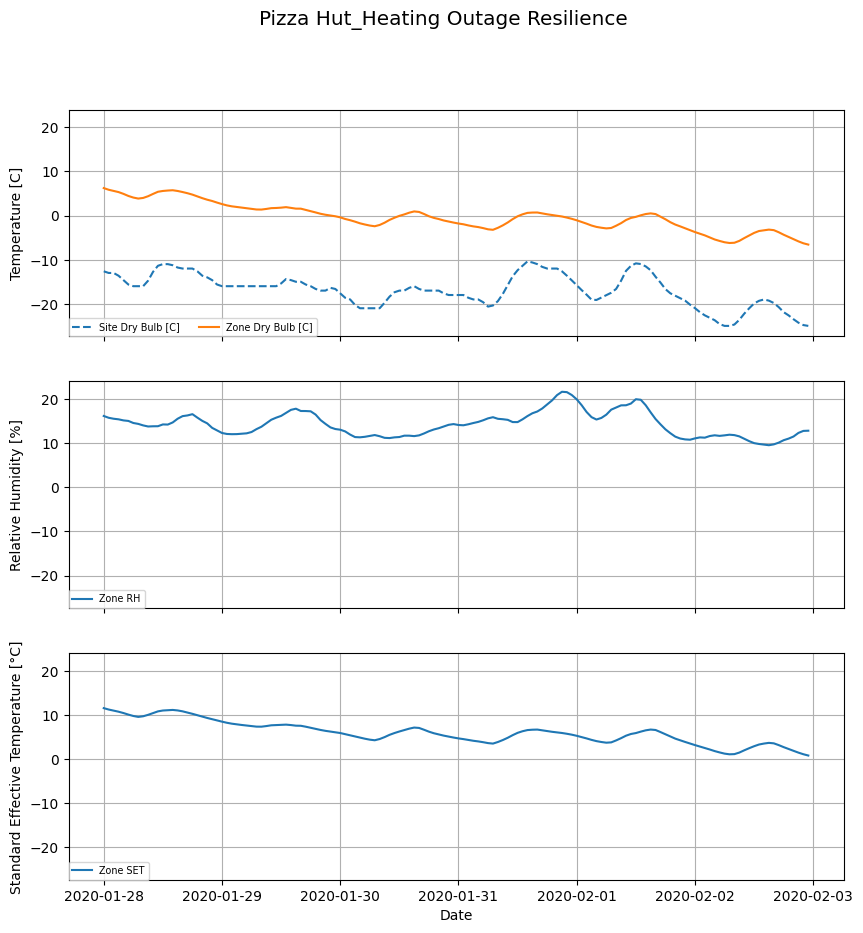

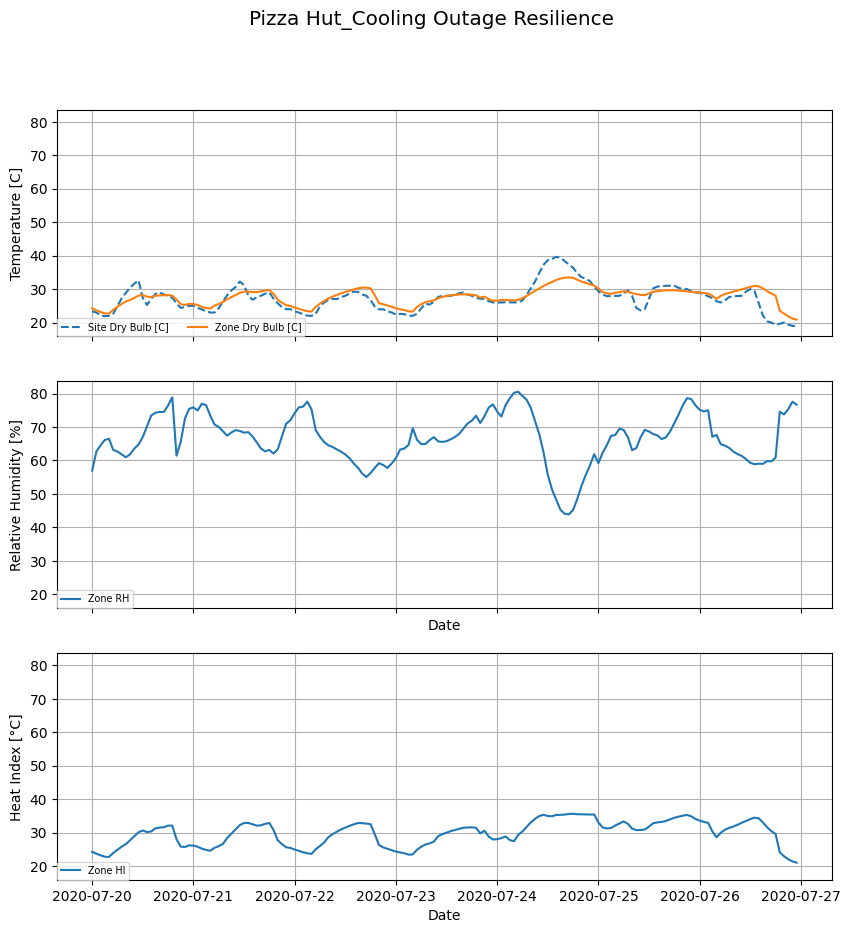

In [76]:
# Resilience Graphs
studyFolder = 'C:/Users/amitc_crl/OneDrive/Documents/GitHub/REVIVE/REVIVE2024/Testing Files/Testing_2023-10-11'

caseName = 'Pizza Hut'

heatingOutageStart = '01/27'
heatingOutageEnd = '02/02'
coolingOutageStart = '07/19'
coolingOutageEnd = '07/26'



######################################################

filehandle = (str(studyFolder) + '\eplusout.csv')
hourly = pd.read_csv(filehandle)
hourlyBA = pd.read_csv(filehandle)

hourly.rename(columns = {'Date/Time':'DateTime'}, inplace = True)
hourly[['Date2','Time']] = hourly.DateTime.str.split(expand=True)
hourly['Date'] = hourly['Date2'].map(str) + '/' + str(2020)
hourly['Time'] = (pd.to_numeric(hourly['Time'].str.split(':').str[0])-1).astype(str).apply(lambda x: f'0{x}' if len(x)==1 else x) + hourly['Time'].str[2:]
hourly['DateTime'] = hourly['Date'] + ' ' + hourly['Time']
hourly['DateTime'] = pd.to_datetime(hourly['DateTime'])

endWarmup = int((hourly[hourly['DateTime'] == '2020-01-01 00:00:00'].index.values))
dropWarmup = [*range(0, endWarmup,1)]

hourly = hourly.drop(index = dropWarmup)
hourly = hourly.reset_index()

heatingOutageStart1 = datetime.strptime((str(heatingOutageStart) + '/' + str(2020)), '%m/%d/%Y') + timedelta(hours=24)
coolingOutageStart1 = datetime.strptime((str(coolingOutageStart) + '/' + str(2020)), '%m/%d/%Y') + timedelta(hours=24)
heatingOutageEnd1 = datetime.strptime((str(heatingOutageEnd) + '/' + str(2020)), '%m/%d/%Y') + timedelta(hours=23)
coolingOutageEnd1 = datetime.strptime((str(coolingOutageEnd) + '/' + str(2020)), '%m/%d/%Y') + timedelta(hours=23)

maskh = (hourly['DateTime'] >= heatingOutageStart1) & (hourly['DateTime'] <= heatingOutageEnd1)
maskc = (hourly['DateTime'] >= coolingOutageStart1) & (hourly['DateTime'] <= coolingOutageEnd1)

hourlyHeat = hourly.loc[maskh]
hourlyCool = hourly.loc[maskc]

x = hourlyHeat['DateTime']

ax1_max = max(hourlyHeat["Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)"],)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True,constrained_layout=False)
fig.suptitle((str(caseName) + '_Heating Outage Resilience'), fontsize='x-large')
ax1.plot(x,hourlyHeat["Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)"], label="Site Dry Bulb [C]", linestyle='dashed')
ax1.plot(x,hourlyHeat["ZONE 1:Zone Air Temperature [C](Hourly)"], label="Zone Dry Bulb [C]")
ax2.plot(x,hourlyHeat['ZONE 1:Zone Air Relative Humidity [%](Hourly)'], label=("Zone RH"))
ax3.plot(x,hourlyHeat['ZONE OCCUPANTS:Zone Thermal Comfort Pierce Model Standard Effective Temperature [C](Hourly)'], label=("Zone SET"))
ax1.grid(True)
ax1.set_ylabel('Temperature [C]')
ax1.legend(ncol=2, loc='lower left', borderaxespad=0, fontsize='x-small')
ax2.legend(ncol=2, loc='lower left', borderaxespad=0, fontsize='x-small')
ax2.grid(True)
ax2.set_ylabel('Relative Humidity [%]')
ax3.legend(ncol=2, loc='lower left', borderaxespad=0, fontsize='x-small')
ax3.grid(True)
ax3.set_xlabel('Date')
ax3.set_ylabel('Standard Effective Temperature [°C]')


# heatingGraphFile = (str(studyFolder) + "/" + str(BaseFileName) + "_Heating Outage Resilience Graphs.png")

# plt.savefig(str(heatingGraphFile), dpi=300)

x = hourlyCool['DateTime']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True,constrained_layout=False)
fig.suptitle((str(caseName) + '_Cooling Outage Resilience'), fontsize='x-large')
ax1.plot(x,hourlyCool["Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)"], label="Site Dry Bulb [C]", linestyle='dashed')
ax1.plot(x,hourlyCool["ZONE 1:Zone Air Temperature [C](Hourly)"], label="Zone Dry Bulb [C]")
ax2.plot(x,hourlyCool['ZONE 1:Zone Air Relative Humidity [%](Hourly)'], label=("Zone RH"))
ax3.plot(x,hourlyCool['ZONE 1:Zone Heat Index [C](Hourly)'], label=("Zone HI"))
ax1.grid(True)
ax1.set_ylabel('Temperature [C]')
ax1.legend(ncol=2, loc='lower left', borderaxespad=0, fontsize='x-small')
ax2.legend(ncol=2, loc='lower left', borderaxespad=0, fontsize='x-small')
ax2.grid(True)
ax2.set_xlabel('Date')
ax2.set_ylabel('Relative Humidity [%]')
ax3.legend(ncol=2, loc='lower left', borderaxespad=0, fontsize='x-small')
ax3.grid(True)
ax3.set_xlabel('Date')
ax3.set_ylabel('Heat Index [°C]')

# coolingGraphFile = (str(studyFolder) + "/" + str(BaseFileName) + "_Cooling Outage Resilience Graphs.png")

# plt.savefig(str(coolingGraphFile), dpi=300)

print(max(hourlyHeat["Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)"].append(hourlyHeat["ZONE 1:Zone Air Temperature [C](Hourly)"])))
